Imports:

In [1]:
import cv2
import PIL
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np

Load the PNG Files:

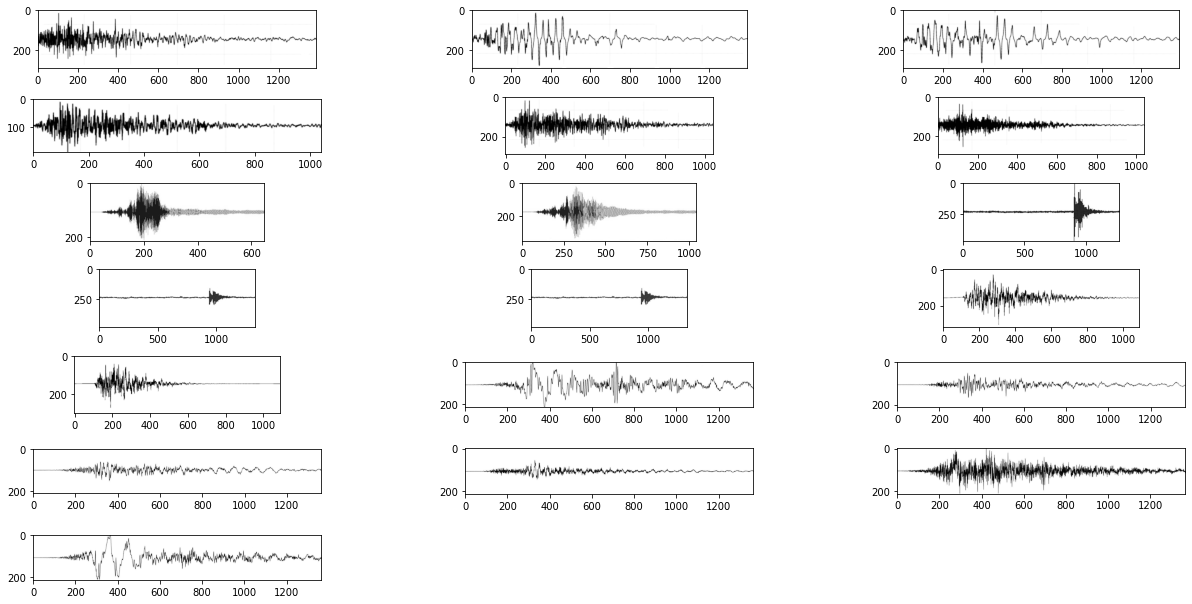

In [2]:
dir = "./drive/MyDrive/Colab Notebooks/EarthQuakeAcc"
imageFiles = [f for f in listdir(dir) if ".png" in f]
#print(imageFiles)

# load the images
images = dict([(imageFile, cv2.imread(join(dir, imageFile), cv2.IMREAD_ANYDEPTH)) for imageFile in imageFiles])

# show the images
def plotImages(images):
  columns = 3
  plt.figure(figsize=(20,10))
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image, cmap='Greys_r')

plotImages(images.values())

Preprocessing:

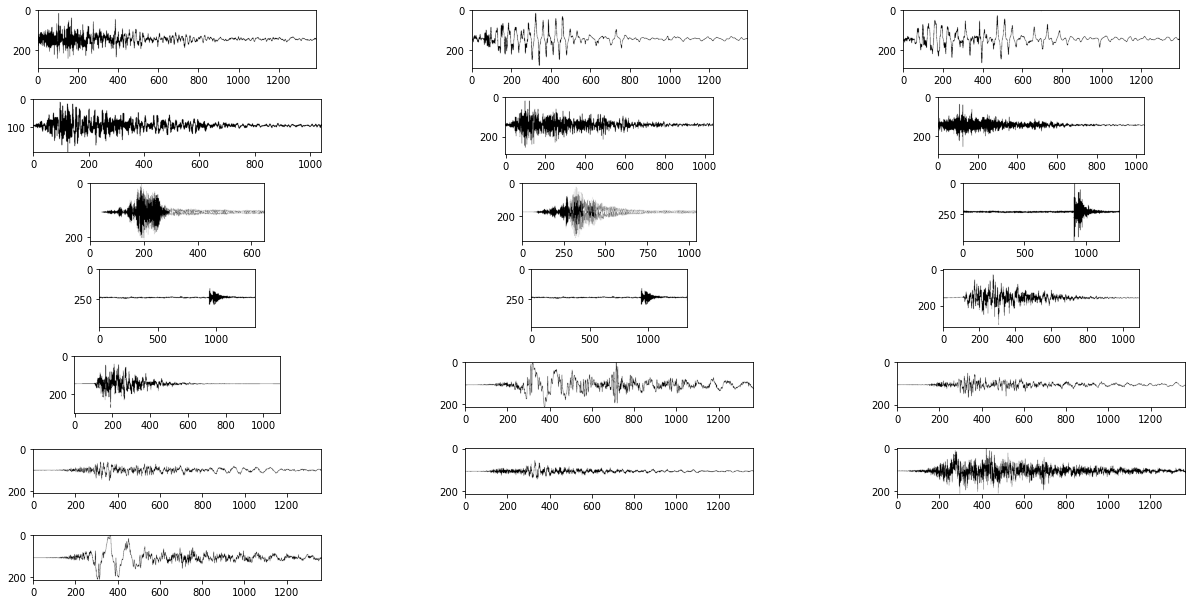

In [3]:
binaryImages = dict((name, cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)[1]) for name,image in images.items())

plotImages(binaryImages.values())

Group the images in data sets and attach metadata to each:

In [17]:
ONE_G = 980.665

dataSets = []

# Source 1, example 1
dataSets.append({
    "Name": "s1-01",
    "X": binaryImages["s1-01-X-scale-1G-60sec.png"],
    "Y": binaryImages["s1-01-Y-scale-1G-60sec.png"],
    "Z": binaryImages["s1-01-Z-scale-1G-60sec.png"],
    "Scale": 1.0 * ONE_G,
    "Time": 60
})

# Source 1, example 2
dataSets.append({
    "Name": "s1-02",
    "X": binaryImages["s1-02-X-scale-0.4G-60sec.png"],
    "Y": binaryImages["s1-02-Y-scale-0.4G-60sec.png"],
    "Z": binaryImages["s1-02-Z-scale-0.2G-60sec.png"],
    "Scale": 0.4 * ONE_G,
    "ScaleZ": 0.2 * ONE_G,
    "Time": 60
})

# Source 2, example 1
dataSets.append({
    "Name": "s2-01",
    "X": binaryImages["s2-01-X-scale-100cms2-300sec.png"],
    "Y": binaryImages["s2-01-Y-scale-100cms2-300sec.png"],
    "Z": None,
    "Scale": 100,
    "Time": 300
})

# Source 3, example 1
dataSets.append({
    "Name": "s3-01",
    "X": binaryImages["s3-01-X-scale-0.34cms2-120sec.png"],
    "Y": binaryImages["s3-01-Y-scale-0.34cms2-120sec.png"],
    "Z": binaryImages["s3-01-Z-scale-0.34cms2-120sec.png"],
    "Scale": 0.34 * ONE_G, # 0.34 ???
    "Time": 120
})

# Source 4, example 1
dataSets.append({
    "Name": "s4-01",
    "X": None,
    "Y": None,
    "Z": None,
    "XYZ": binaryImages["s4-01-XYZ-scale-0.75g-50sec.png"],
    "Scale": 0.75 * ONE_G,
    "Time": 50
})

# Source 4, example 2
dataSets.append({
    "Name": "s4-02",
    "X": None,
    "Y": None,
    "Z": None,
    "XYZ": binaryImages["s4-02-XYZ-scale-0.75g-50sec.png"],
    "Scale": 0.75 * ONE_G,
    "Time": 50
})

# Source 5, example 1
dataSets.append({
    "Name": "s5-01",
    "X": binaryImages["s5-01-X-scale-150cms2-70sec.png"],
    "Y": binaryImages["s5-01-Y-scale-150cms2-70sec.png"],
    "Z": binaryImages["s5-01-Z-scale-150cms2-70sec.png"],
    "Scale": 150,
    "Time": 70
})

dataSets.append({
    "Name": "s5-02",
    "X": binaryImages["s5-02-X-scale-150cms2-70sec.png"],
    "Y": binaryImages["s5-02-Y-scale-150cms2-70sec.png"],
    "Z": binaryImages["s5-02-Z-scale-150cms2-70sec.png"],
    "Scale": 150,
    "Time": 70
})

print("Datasets: " + str(len(dataSets)))

Datasets: 8


Transform the images into time series:

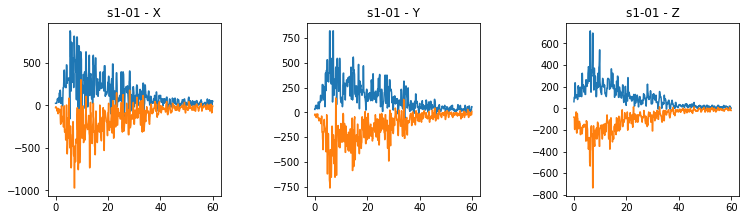

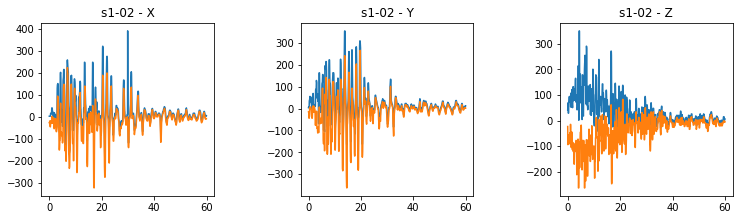

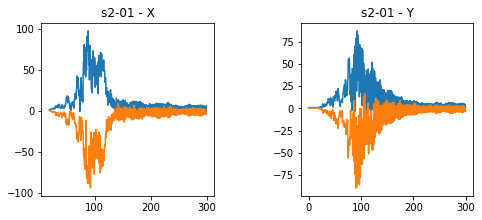

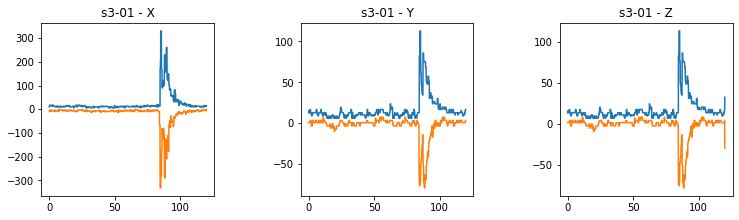

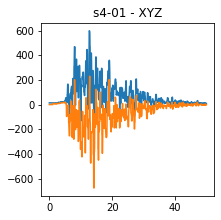

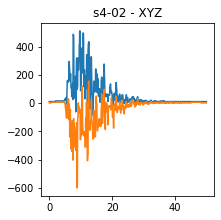

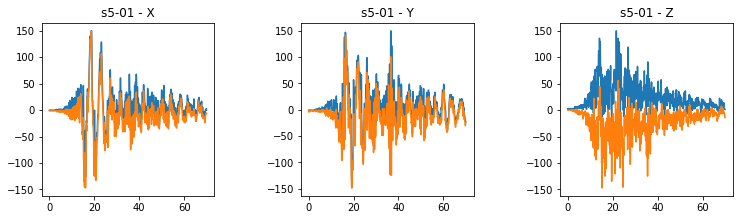

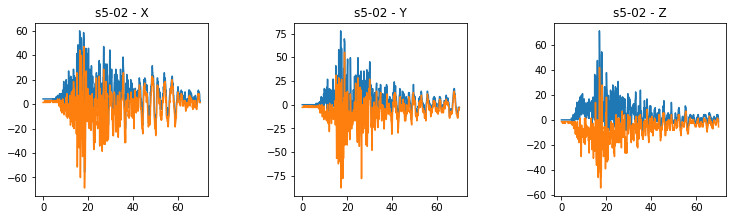

In [18]:
class Point():
  def __init__(self, min, max, time):
    self.min = min
    self.max = max
    self.time = time

  def __str__(self):
    return "Point[t={},min={},max={}]".format(self.time, self.min, self.max)

def processImage(image, scale, time):
  # we will calculate a min and a max value for each pixel
  h = image.shape[0]
  w = image.shape[1]
  points = []
  for x in range(0, w):
    minPixVal = 9999
    maxPixVal = 0
    for y in range(0, h):    
      # threshold the pixel
      pixVal = image[y, x]
      if pixVal > 0:
        continue
      minPixVal = y if y < minPixVal else minPixVal
      maxPixVal = y if y > maxPixVal else maxPixVal
    
    if maxPixVal == 0:
      continue

    currentTime = time * x / w
    minValue = 2 * scale * (h / 2 - minPixVal) / h
    maxValue = 2 * scale * (h / 2 - maxPixVal) / h
    points.append(Point(minValue, maxValue, currentTime))

  return points

subplots = 0
def plotPoints(points, name): 
  global subplots 
  ax = plt.subplot(1, 3, subplots)
  ax.set_title(name)
  subplots = subplots + 1
  x = [point.time for point in points]
  ymin = [point.min for point in points]
  ymax = [point.max for point in points]
  ax.plot(x, ymin)
  ax.plot(x, ymax)

for dataSet in dataSets:
  name = dataSet["Name"]
  scale = dataSet["Scale"]
  time = dataSet["Time"]  
   
  fig = plt.figure(figsize=(12,3))
  #fig.canvas.set_window_title('Window Title')
  #ax = fig.add_axes([0, 0, 1, 1])
  #ax.set_title(dataSet["Name"])
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

  subplots = 1

  if dataSet["X"] is not None:
    dataSet["pointsX"] = processImage(dataSet["X"], scale, time)    
    plotPoints(dataSet["pointsX"], name + " - X")
  
  if dataSet["Y"] is not None: 
    dataSet["pointsY"] = processImage(dataSet["Y"], scale, time)
    plotPoints(dataSet["pointsY"], name + " - Y")
  
  if dataSet["Z"] is not None:
    dataSet["pointsZ"] = processImage(dataSet["Z"], scale, time)    
    plotPoints(dataSet["pointsZ"], name + " - Z")

  if "XYZ" in dataSet:
    dataSet["pointsXYZ"] = processImage(dataSet["XYZ"], scale, time)
    plotPoints(dataSet["pointsXYZ"], name + " - XYZ")
  

#plt.imshow(dataSets[0]["X"], cmap='Greys_r', alpha=0.25)


#print(points[10])
#print(points[0:10])


Let's determine the frequency of each data set:

In [19]:
for dataSet in dataSets:
  name = dataSet["Name"]
  time = dataSet["Time"]
  x = dataSet["X"].shape[0] if dataSet["X"] is not None else dataSet["XYZ"].shape[0]
  freq = x/time
  print("{} freq={}".format(name, freq)) 

s1-01 freq=3.183333333333333
s1-02 freq=4.833333333333333
s2-01 freq=0.7133333333333334
s3-01 freq=3.9
s4-01 freq=6.4
s4-02 freq=6.1
s5-01 freq=3.0285714285714285
s5-02 freq=3.0


It's about 1-6 Hz.

Let's try to interpolate this to 100 Hz:

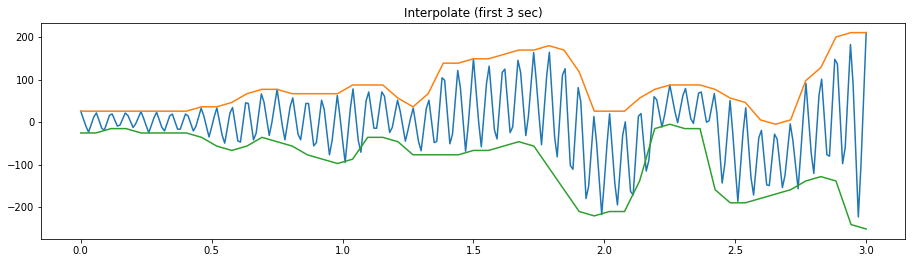

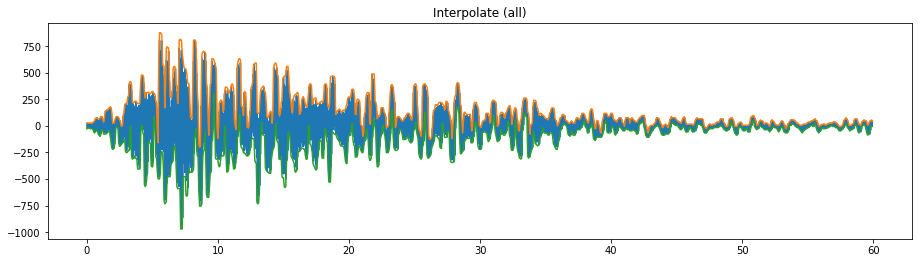

In [20]:
def interpolate(points, startTime, endTime, freq):
  result = []
  step = 1 / freq
  idx = 0
  curPoint = points[idx]
  nextPoint = points[idx + 1]
  minFirst=True
  t = max(startTime, curPoint.time)
  while t < endTime:
    if t < curPoint.time:      
      t = curPoint.time
      print("{} {} {} {} {}".format(t, curPoint.min, curPoint.max, nextPoint.min, nextPoint.max))
      
    if t >= nextPoint.time:
      idx = idx + 1
      curPoint = points[idx]
      if idx >= len(points) - 1:
        break        
      nextPoint = points[idx + 1]
    
    perc = (t - curPoint.time) / (nextPoint.time - max(startTime, curPoint.time))
    stepPerc = step / (nextPoint.time - max(startTime, curPoint.time))
    if perc <= 0.5:
      perc = perc * 2
      val = curPoint.min * (1 - perc) + curPoint.max * perc

    else:
      perc = (perc - 0.5) * 2
      val = curPoint.max * (1 - perc) + nextPoint.min * perc
    
    result.append(Point(val,val,t))

    t = t + step

  return result

# interpolate, time = 0 - 30 sec, freq = 100 Hz
res = interpolate(dataSets[0]['pointsX'], 0, 60, 100)

# plot the first 3 seconds
fig = plt.figure(figsize=(12,3))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Interpolate (first 3 sec)")

x = [p.time for p in res if p.time <= 3]
y = [p.min for p in res if p.time <= 3]
ax.plot(x, y)

x = [p.time for p in dataSets[0]['pointsX'] if p.time <= 3]
y = [p.min for p in dataSets[0]['pointsX'] if p.time <= 3]
ax.plot(x, y)

x = [p.time for p in dataSets[0]['pointsX'] if p.time <= 3]
y = [p.max for p in dataSets[0]['pointsX'] if p.time <= 3]
ax.plot(x, y)

# plot all
fig = plt.figure(figsize=(12,3))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Interpolate (all)")

x = [p.time for p in res]
y = [p.min for p in res]
ax.plot(x, y)

x = [p.time for p in dataSets[0]['pointsX']]
y = [p.min for p in dataSets[0]['pointsX']]
ax.plot(x, y)

x = [p.time for p in dataSets[0]['pointsX']]
y = [p.max for p in dataSets[0]['pointsX']]
ax.plot(x, y)

Now we can generate some segments at 100 Hz with X+Y+Z accelerometer data:

18.952234206471495 0.9345794392523364 0.0
0.0 0.8695652173913043 0.2898550724637681
18.952234206471495 0.7233234098653863 0.0


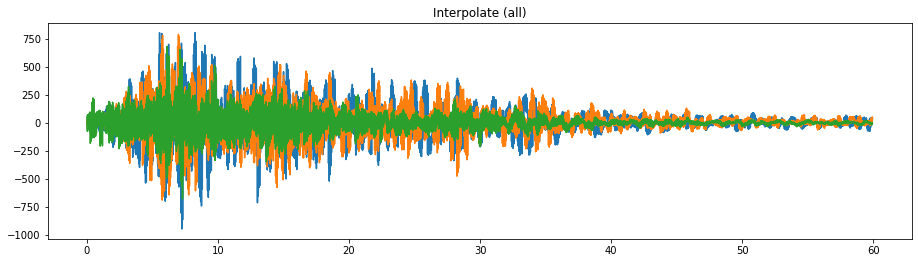

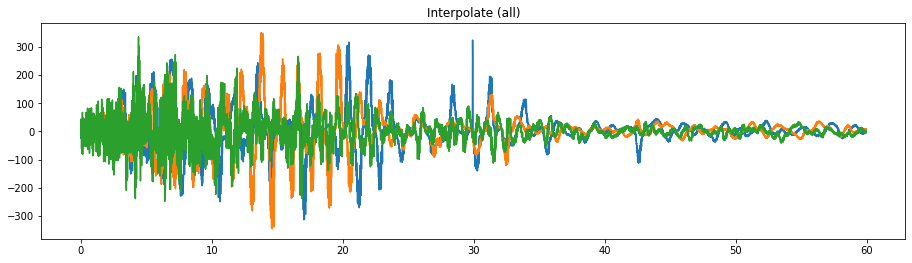

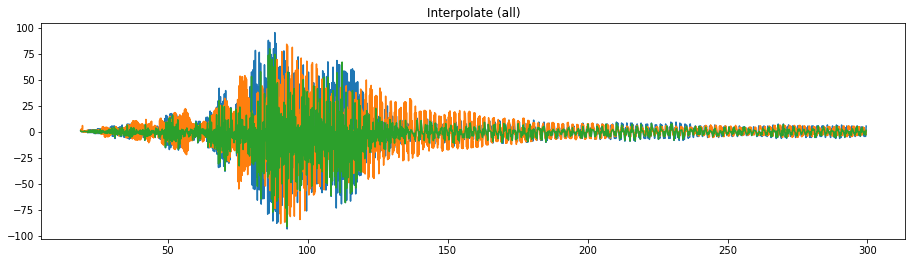

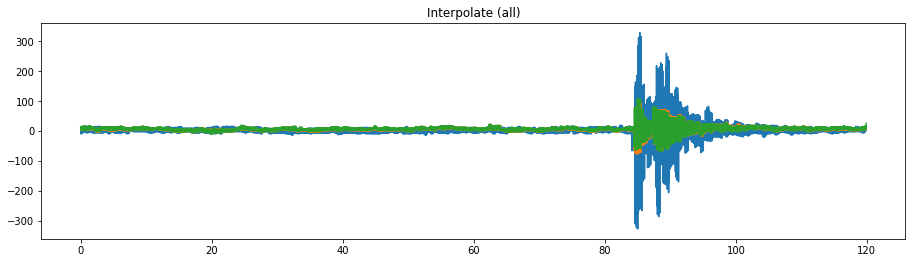

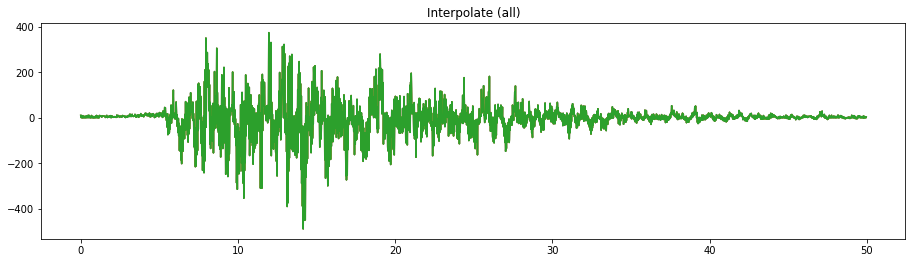

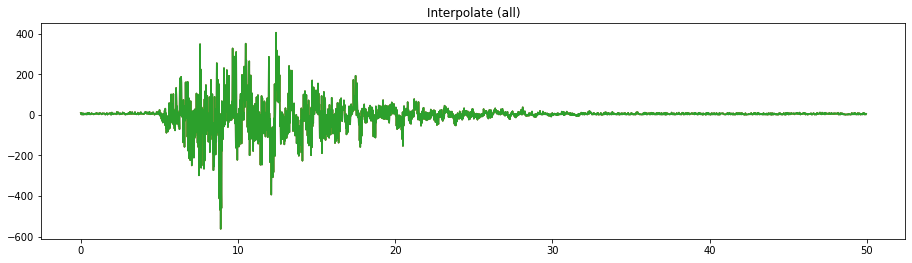

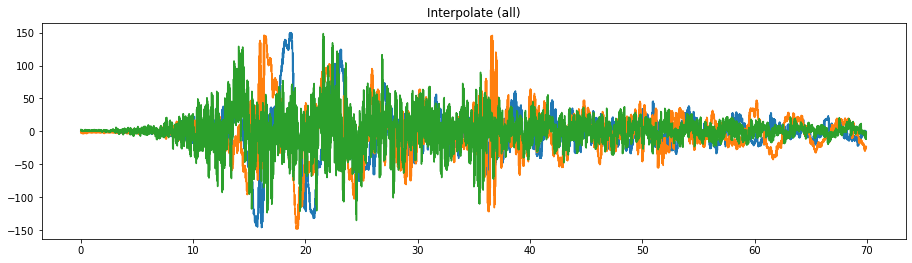

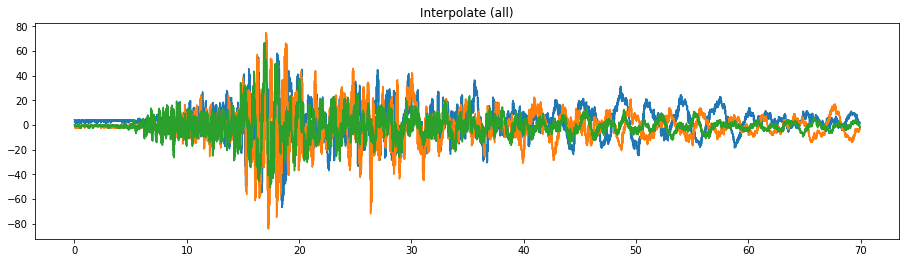

In [21]:
randomSeed = 42
def randomizedCopy(points, randPerc):
  rng = np.random.default_rng(randomSeed)
  res = []
  for point in points:
    min = point.min * (1 - randPerc + 2 * (rng.random() - 0.5) * randPerc)
    max = point.max * (1 - randPerc + rng.random() * randPerc)
    res.append(Point(min, max, point.time))
  return res

freq = 100
segments = []
for dataSet in dataSets:
  name = dataSet["Name"]
  scale = dataSet["Scale"]
  time = dataSet["Time"]

  if "pointsXYZ" in dataSet:
    X = randomizedCopy(dataSet["pointsXYZ"], 0.5)
    Y = randomizedCopy(dataSet["pointsXYZ"], 0.5)
    Z = randomizedCopy(dataSet["pointsXYZ"], 0.5)

  elif "pointsZ" not in dataSet:
    X = dataSet["pointsX"]
    Y = dataSet["pointsY"]
    #Z = dataSet["pointsY"]
    print("{} {} {}".format(X[0].time, X[0].min, X[0].max))
    print("{} {} {}".format(Y[0].time, Y[0].min, Y[0].max))
    Z = randomizedCopy(dataSet["pointsX"], 0.5)
    print("{} {} {}".format(Z[0].time, Z[0].min, Z[0].max))
    
  else:
    X = dataSet["pointsX"]
    Y = dataSet["pointsY"]
    Z = dataSet["pointsZ"]
  
  tStart = max(X[0].time, Y[0].time, Z[0].time)
  tEnd = min(X[-1].time, Y[-1].time, Z[-1].time)
  #tEnd = 20

  segX = interpolate(X, tStart, tEnd, freq)
  segY = interpolate(Y, tStart, tEnd, freq)
  segZ = interpolate(Z, tStart, tEnd, freq)
  
  fig = plt.figure(figsize=(12,3))
  ax = fig.add_axes([0, 0, 1, 1])
  ax.set_title("Interpolate (all)")

  x = [p.time for p in segX]
  y = [p.min for p in segX]
  y2 = [p.min for p in segY]
  y3 = [p.min for p in segZ]
  ax.plot(x, y)
  ax.plot(x, y2)
  ax.plot(x, y3)

  segments.append((segX, segY, segZ))

Now we can concatenate the segments into a bigger time-series:

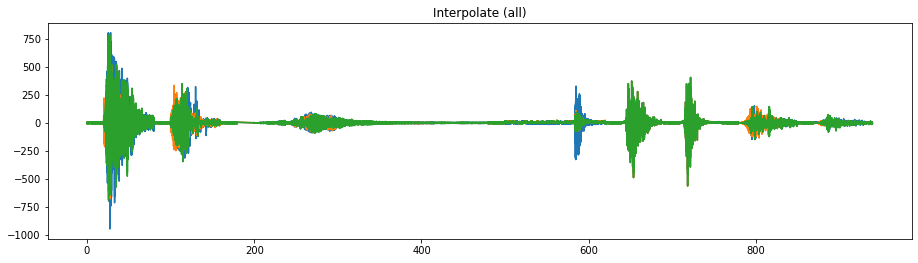

In [38]:
def randomIdle(freq, time, const = 8):
    rng = np.random.default_rng(randomSeed)
    step = 1 / time
    t = 0
    res = []
    while t < time:
      value = const * rng.random() * (1 if rng.random() > 0.5 else -1)
      res.append(Point(value, value, t))
      t = t + step
    return res

def adjustTime(points, adj):
  return [Point(p.min, p.max, p.time + adj) for p in points]

def concatenate(segments, freq, idle):
  time = 0
  step = 1 / freq
  Xres, Yres, Zres = [], [], []
  for segment in segments:    
    idleX = adjustTime(randomIdle(freq, idle), time)
    idleY = adjustTime(randomIdle(freq, idle), time)
    idleZ = adjustTime(randomIdle(freq, idle), time)

    time = time + idle + step
    #print(time)

    (X, Y, Z) = segment
    Xadj = adjustTime(X, time)
    Zadj = adjustTime(Y, time)
    Yadj = adjustTime(Z, time)

    time = Xadj[-1].time + step

    Xres.extend(idleX)
    Xres.extend(Xadj)
    Yres.extend(idleY)
    Yres.extend(Yadj)
    Zres.extend(idleZ)
    Zres.extend(Zadj)
  
  return Xres, Yres, Zres

freq = 100
idle = 20

Xres, Yres, Zres = concatenate(segments, freq, idle)

# plot
fig = plt.figure(figsize=(12,3))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Interpolate (all)")

x = [p.time for p in Xres]
y = [p.min for p in Xres]
y2 = [p.min for p in Yres]
y3 = [p.min for p in Zres]
ax.plot(x, y)
ax.plot(x, y2)
ax.plot(x, y3)


We need more samples!

876.4030247763582
318.77248507544135
94.4243613641432
328.20705534921694
430.7574047236856
484.2414626402424
148.01239892196352
62.452244897921425


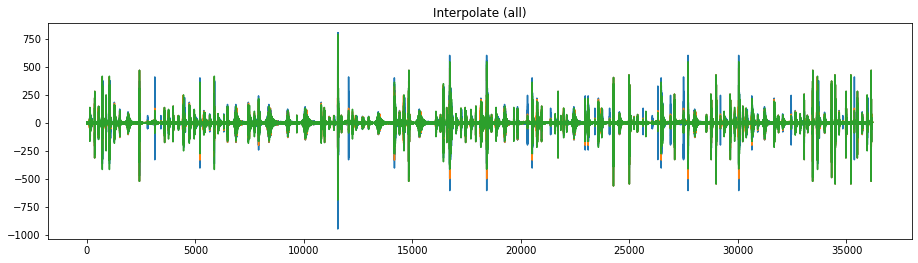

In [40]:
def scale(points, ampScale, timeScale):
  return [Point(ampScale * p.min, ampScale * p.max, timeScale * p.time) for p in points]

timeScaling = [0.5, 1.5, 2, 3]
scaledSegments = []
for segment in segments:
  (X, Y, Z) = segment
  Xmin = min([p.min for p in X])
  Ymin = min([p.min for p in X])
  Zmin = min([p.min for p in X])
  Xmax = max([p.max for p in X])
  Ymax = max([p.max for p in X])
  Zmax = max([p.max for p in X])
  avgLimits = ((Xmax + Ymax + Zmax) - (Xmin + Ymin + Zmin)) / 6  
  print(avgLimits)
  if avgLimits > 700:
    ampScaling = [0.1, 0.3, 0.5, 0.75]
  elif avgLimits > 300:
    ampScaling = [0.2, 0.4, 0.75, 1.25]
  elif avgLimits > 100:
    ampScaling = [0.4, 0.75, 1.25, 1.5]
  else:
    ampScaling = [1.2, 1.5, 1.75, 2]

  scaledSegments.append((X, Y, Z))
  for timeScale in timeScaling:
    for ampScale in ampScaling:
      Xscaled = randomizedCopy(scale(X, ampScale, timeScale), 0.2)
      Yscaled = randomizedCopy(scale(Y, ampScale, timeScale), 0.2)
      Zscaled = randomizedCopy(scale(Z, ampScale, timeScale), 0.2)
      scaledSegments.append((Xscaled, Yscaled, Zscaled))

import random
random.shuffle(scaledSegments)

Xres, Yres, Zres = concatenate(scaledSegments, freq, 100)

# plot
fig = plt.figure(figsize=(12,3))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Interpolate (all)")

x = [p.time for p in Xres]
y = [p.min for p in Xres]
y2 = [p.min for p in Yres]
y3 = [p.min for p in Zres]
ax.plot(x, y)
ax.plot(x, y2)
ax.plot(x, y3)


Export as CSV:

In [49]:
import csv

ONE_G_14_BIT = 4096
CONV_CONST = ONE_G_14_BIT / ONE_G
print(CONV_CONST)

with open(dir + "/data.csv", 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)    
    print(len(Xres), len(Yres), len(Zres))
    csvwriter.writerow(["Time", "AccX", "AccY", "AccZ"])
    for (x, y, z) in zip(Xres, Yres, Zres):
      csvwriter.writerow([x.time, x.min * CONV_CONST, y.min * CONV_CONST, z.min * CONV_CONST])

4.176757608357594
2652391 2652391 2652391
